# MTGNNe - Hyperparameter Optimization (2/2)

Daniel Alejandro Alonso Bastos

El objetivo de esta libreta es extender el framework para utilizar una librería de configuración automática de algoritmos, específicamente [Optuna](https://github.com/optuna/optuna)

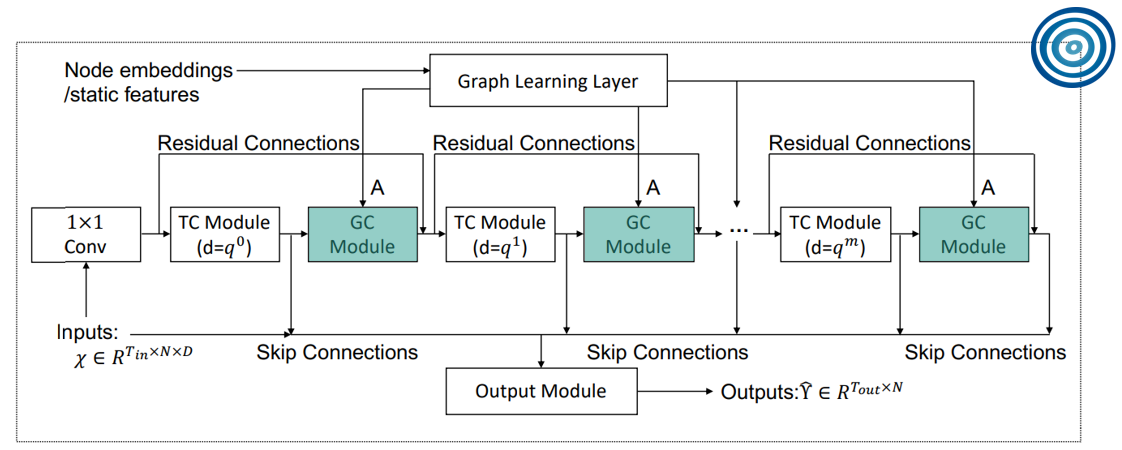

En el notebook `3-mtgnne-opt-0` se realizó un ejercicio de optimización de hiperparámetros, el cual tuvo un RMSE de 0.00429, un valor alto para los resultados obtenidos de las arquitecturas MTGNN y MTGNNAH. Una hipótesis es que el espacio de búsqueda es muy amplio, por lo que, para lograr una optimización sin tomar muchos tiempos lo que se traduce en tiempo, se decidió mantener los hiperparámetros de mayor de importancia del ejercicio anterior, mientras que los otros se regresaron sus valores a los originales.

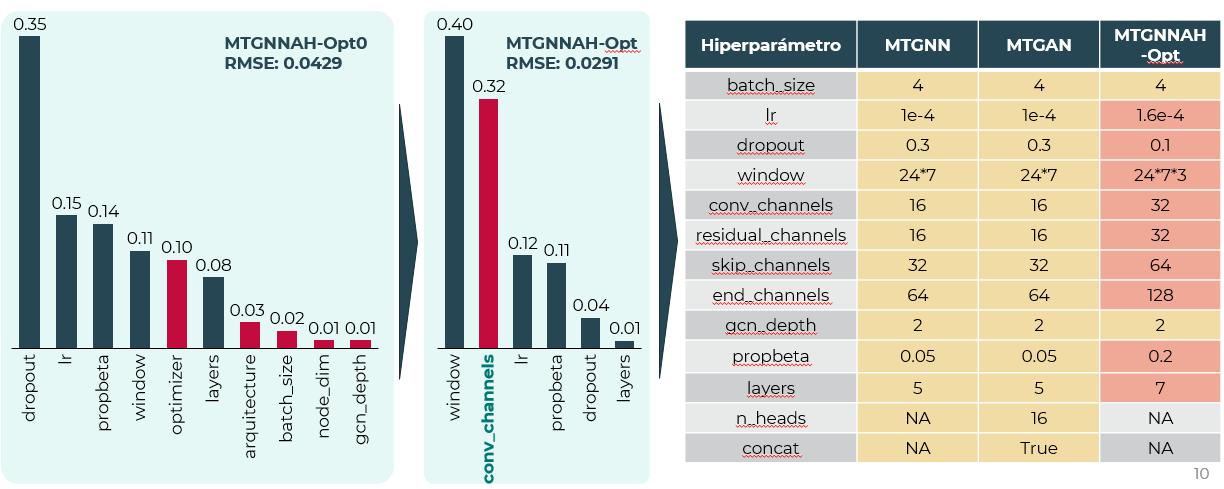

Esta libreta es prácticamente la misma que `3-mtgnne-opt-0` , con la diferencia de que se optimizan menos hiperparámetros.

## 1 Preparación

### 1.1 Bibliotecas

Instalación de bibliotecas

In [1]:
#! pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113 
# inspeccionar arquitecturas
#! pip install torchinfo
# barras de progreso
#! pip install tqdm
# optuna
#! pip install optuna
# visualizador de datos interactivos -> plotly
#! pip install plotly

Nota: Las siguientes librerías son para utilizar [PyTorch Geometric Temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html), que tiene cargado los [modelos](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html) ST-GNN, incluido el de [MTGNN](https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/attention/mtgnn.html#MTGNN), **pero no es necesario instalarlo** dado que todo el proyecto está realizado con PyTorch y el modelo MTGNN se tiene en el archivo `MTGNN.py` en el directorio de este notebook. Además la instalación es tardada y a veces complicada.

In [19]:
#! pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#! pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#! pip install torch-geometric
#! pip install torch-geometric-temporal

En el directorio del notebook se encuentran 2 archivos .py:
* `MTGNN.py` es donde se encuentra la clase `MTGNN`, que es la implementación original.
* `MTGNNe.py` es donde se encuentra la clase `MTGNNe` que es la extensión al modelo original implementando las 2 modificaciones propuestas, en la cual también se puede obtener el modelo MTGNN modificando el parámetro `arquitecture = MTGNN`

Dentro del archivo `MTGNNe.py` se encuentra la clase `MTGNNe_Opt2`, que es una modificación a `MTGNNe` para realizar la optimización de hiperpárametros, al tomar rangos de los hiperparámetros a optimizar. Además, realiza la optimización sobre menos hiperparámetros a diferencia de la clase `MTGNNe_Opt`

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random

# redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets.utils as tvu

# optimzacion de hiperparametros
import optuna

# carga del modelo MTGNNe_Opt (que esta en el mismo directorio que el notebook)
#from MTGNN import MTGNN
#from MTGNNe import MTGNNe
#from MTGNNe import MTGNNe_Opt
from MTGNNe import MTGNNe_Opt2

# inspección de arquitectura
from torchinfo import summary

# descompresion
import gzip

# barras de progreso
from tqdm.auto import trange
from tqdm.auto import tqdm

## 1.2 Auxiliares

In [3]:
# parametros para graficas
MARKER = 'o'
MARKER_SIZE = 4

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

# descomprimir los archivos txt.gz -> txt
def decompress(infile, tofile):
    with open(infile, 'rb') as inf, open(tofile, 'w', encoding='utf8') as tof:
        decom_str = gzip.decompress(inf.read()).decode('utf-8')
        tof.write(decom_str)

def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))

# grafica de perdidas
def display_losses(losses, title='Model loss', plot=True, path2save=None):
    train_loss, test_loss = zip(*losses)
    # eje x (numero enteros [1,epocas])
    x = np.arange(1,len(train_loss)+1, dtype=np.int8)
    plt.figure(figsize=(8, 4))
    plt.plot(x,train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
    plt.plot(x,test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
    #plt.ylim([0,100])
    plt.xticks(x)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid()
    plt.legend()
    # guardar grafica
    if path2save is not None:
        plt.savefig(path2save)
    if not plot: 
        plt.close()
    else:
        plt.show()

# convierte una matriz de adyacencia en un tensor de aristas con sus pesos
# esto es para poder ocupar arquitecturas de torch-geometric
# NOTA: no se utiliza en el proyecto, pero como trabajo a futuro, el modelo MTGNNe puede implementar
# bloques de torch-geometric, para lo que es necesario tener la lista de aristas con sus pesos
def edges_from_adjacency(A):
    '''
    Funcion para obtener la lista de aristas y sus pesos en formato de pytorch geomtric
    A: matriz de adyacencia
    '''
    # obtener la lista de indices
    edge_index = A.nonzero().t().contiguous()
    # obtener los pesos
    n_connections = edge_index.shape[1] # numero de conexiones
    edge_weight = torch.zeros(n_connections) # inicializar tensor de pesos
    # iterar en cada conexion
    for edge in range(n_connections):
        row = edge_index[0,edge].item() # nodo origen
        column = edge_index[1,edge].item() # nodo destino
        # obtencion del peso de la matriz de adyacencia A
        weight = A[row, column].item()
        # actualizacion en el tensor de pesos
        edge_weight[edge] = weight
    
    return edge_index, edge_weight

## 2 Datos

### 2.1 Descarga de datos

Para la descarga de datos se implementó la clase `TSDatasets`, que toma como entrada la carpeta a guardar los datos `root`, el dataset que se quiere [descargar](https://github.com/laiguokun/multivariate-time-series-data):
* [Electricity consumption](https://github.com/laiguokun/multivariate-time-series-data/tree/master/electricity)
* [Traffic Ussage](https://github.com/laiguokun/multivariate-time-series-data/tree/master/traffic)
* [Solar Energy](https://github.com/laiguokun/multivariate-time-series-data/tree/master/solar-energy)
* [Exchange Rate](https://github.com/laiguokun/multivariate-time-series-data/tree/master/exchange_rate)

Dentro de la clase se descarga y se descomprimen los datos en la carpeta `root`, en caso de que ya existan los datos en la carpeta, solo se mostrará un mensaje diciendo que ya se tienen los datos si se tiene activado el despliegue de mensaje `verbose_download = True`

**Nota: En la clase solo se pueden descargar los benchmark de las series de tiempo que no tienen una estructura de grafo definida**

In [4]:
class TSDatasets():
    '''Descarga y descompresion de los datos de series de tiempo'''
    def __init__(self, root='../data', dataset='electricity', verbose_download=True):
        self.root = root # carpeta root para descargar los archivos
        # diccionario con los distintos datos de series de tiempo
        self.filenames = {
            'electricity': 'electricity.txt.gz',
            'exchange_rate': 'exchange_rate.txt.gz',
            'solar-energy': 'solar_AL.txt.gz',
            'traffic': 'traffic.txt.gz'
        }
        # diccionario con las URLs de descarga para cada conjunto de datos
        self.URLS = {
            'electricity': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/electricity/electricity.txt.gz?raw=true',
            'exchange_rate': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/exchange_rate/exchange_rate.txt.gz?raw=true',
            'solar-energy': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/solar-energy/solar_AL.txt.gz?raw=true',
            'traffic': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/traffic/traffic.txt.gz?raw=true'
        }
        self.filename = self.filenames[dataset] # nombre del archivo .txt.gz
        # path para guardar el archivo txt.gz del conjunto deseado
        self.data_dir = os.path.join(root, self.filename)
        self.URL = self.URLS[dataset] # URL de descarga del conjunto deseado
        # path del archivo txt para descomprimir la informacion
        self.file_txt = os.path.join(root, dataset + '.txt')
        # crear carpeta root (en caso de no existir)
        self.create_root()
        # descargar y descomprimir los datos
        self.download(verbose_download)

    def _check_integrity_download(self):
        return os.path.isfile(self.data_dir)

    def _check_integrity_extract(self):
        return os.path.isfile(self.file_txt)

    def create_root(self):
        if not os.path.isdir(self.root):
            os.makedirs(self.root)

    def _extract(self,root, filename):
        # crear archivo txt de escritura si no existe
        if not os.path.isfile(self.file_txt):
            f = open(self.file_txt, "x")

        # extraer
        decompress(self.data_dir, self.file_txt)

    def download(self, verbose):
        # revisar si los archivos estan descargados y descomprimidos
        if self._check_integrity_download():
            if verbose: print('Files already downloaded')
            if self._check_integrity_extract():
                if verbose: print('Files already decompressed')
                return

        # descarga
        tvu.download_url(
            url=self.URL,
            root=self.root,
            filename=self.filename
        )
        # extraccion
        self._extract(self.root, self.filename)

### 2.2 Cargador de datos

Modificación al `DataLoaderS` original para que sea más transparente en la lógica, creando así la clase `DataLoaderS2`. Para mayor información referir al notebook `1-mtgnne-complete`.

In [5]:
class DataLoaderS2(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train_ratio, valid_ratio, device, horizon, window, normalize=2):
        self.window = window
        self.horizon = horizon
        fin = open(file_name) # abrir el archivo
        self.rawdat = np.loadtxt(fin, delimiter=',') # separar txt por comas
        self.dat = np.zeros(self.rawdat.shape) # inicializar del tamanio de rawdata (filas, columnas)
        self.rows, self.attrs = self.dat.shape # rows -> tuplas, attrs -> variables -> num de nodos
        self.num_nodes = self.attrs # los nodos son las variables
        self.normalize = 2
        self.scale = np.ones(self.attrs) # de tamanio del numero de nodos (atributos)
        self._normalized(normalize)
        # separar el conjunto en diferentes conjuntos: entrenamiento, validacion, y prueba
        self._split(int(train_ratio * self.rows), int((train_ratio + valid_ratio) * self.rows), self.rows)

        self.scale = torch.from_numpy(self.scale).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.attrs)

        self.scale = self.scale.to(device)
        self.scale = Variable(self.scale)

        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))

        self.device = device

    def _normalized(self, normalize):
        # normalized by the maximum value of entire matrix.

        if (normalize == 0):
            self.dat = self.rawdat

        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat)

        # normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.attrs):
                self.scale[i] = np.max(np.abs(self.rawdat[:, i]))
                self.dat[:, i] = self.rawdat[:, i] / np.max(np.abs(self.rawdat[:, i]))

    def _split(self, train_size, valid_size, test_size):
        # generar los rangos para cada conjunto 
        train_range = range(self.window + self.horizon - 1, train_size)
        valid_range = range(train_size, valid_size)
        test_range = range(valid_size, test_size)
        # generar los tensores X, Y para cada conjunto
        self.train = self._batchify(train_range, self.horizon)
        self.valid = self._batchify(valid_range, self.horizon)
        self.test = self._batchify(test_range, self.horizon)

    def _batchify(self, set_range, horizon):
        # set_range -> es el rango del conjunto (entrenamiento, prueba o valid)
        # generar tensores X, Y
        n_set = len(set_range) # tamanio del rango del conjunto
        # inicializar tensores
        # [R,W,N]
        # R -> filas (tuplas), W -> ventana de tiempo, N -> nodos
        X = torch.zeros((n_set, self.window, self.attrs)) 
        # [R,N]
        Y = torch.zeros((n_set, self.attrs))
        # llenar los tensores al recorrer la ventana de tiempo y horizonte
        for i in range(n_set):
            end = set_range[i] - self.horizon + 1 # idx de inicio de la ventana de tiempo
            start = end - self.window # idx de fin de la ventana de tiempo
            # colocar valores de la ventana en X
            X[i, :, :] = torch.from_numpy(self.dat[start:end, :])
            # colocar valor de ventana + horizonte como Y
            Y[i, :] = torch.from_numpy(self.dat[set_range[i], :])
        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]
            Y = targets[excerpt]
            X = X.to(self.device)
            Y = Y.to(self.device)
            yield Variable(X), Variable(Y)
            start_idx += batch_size

## 3 Modelo

Instancia de las distintas arquitecturas:
* **MTGNN** es la arquitectura original propuesta en el artículo.
* **MTGAN** es la arquitectura que implementa mecanismos de atención al agregar la información de un nodo con sus vecinos.
* **MTGNNAH** es la arquitectura **MTGNN** con mecanismos de atención al propagar la información en el número de capas de la GCN.
* **MTGANAH** es la arquitectura **MTGAN** con mecanismos de atención al propagar la información en el número de capas de la GCN.

Dentro de la clase `MTGNNe` del archivo `MTGNNe.py` se puede obtener cada arquitectura al variar el parámetro `arquitecture`. Los parámetros del modelo `MTGNN` se mantienen en la clase `MTGNNe` con 3 parámetros adicionales que son `arquitecture`, `n_heads`, `concat`. A continuación se desriben los paraémtros de `MTGNNe`:

* `gcn_true` (bool): Whether to add graph convolution layer.
* `build_adj` (bool): Whether to construct adaptive adjacency matrix.
* `gcn_depth` (int): Graph convolution depth.
* `num_nodes` (int): Number of nodes in the graph.
* `kernel_set` (list of int): List of kernel sizes.
* `kernel_size` (int): Size of kernel for convolution, to calculate receptive field size.
* `dropout` (float): Droupout rate.
* `subgraph_size` (int): Size of subgraph.
* `node_dim` (int): Dimension of nodes.
* `dilation_exponential` (int): Dilation exponential.
* `conv_channels` (int): Convolution channels.
* `residual_channels` (int): Residual channels.
* `skip_channels` (int): Skip channels.
* `end_channels` (int): End channels.
* `seq_length` (int): Length of input sequence (window).
* `in_dim` (int): Input dimension.
* `out_dim` (int): Output dimension.
* `layers` (int): Number of layers.
* `propbeta` (float): Prop beta, ratio of retaining the root nodes's original states in mix-hop propagation, a value between 0 and 1.
* `tanhalpha` (float): Tanh alpha for generating adjacency matrix, alpha controls the saturation rate.
* `layer_norm_affline` (bool): Whether to do elementwise affine in Layer Normalization.
* `xd` (int, optional): Static feature dimension, default None.
* `arquitecture` (str): Type of arquitecture to use ('MTGNN'->original, 'MTGAN'->attention in adj_matrix, 'MTGNNAH'->MTGNN with attention in hops,'MTGANAH'->MTGAN with attention in hops)
* `n_heads` (int): Number of attention heads, in case to use MTGAN or MTGANAH
* `concat` (bool): Whether the multi-head results should be concatenated or averaged, in case to use MTGAN or MTGANAH

El número de nodos se obtiene directamente del `DataLoaderS2`, que es el número de variables en la base de datos

## 4 Ciclo de entrenamiento

El ciclo de entrenamiento se mantuvo con la idea del [original](https://github.com/nnzhan/MTGNN/blob/master/train_single_step.py), pero con la estructura del ciclo de entrenamiento que se ha manejado a lo largo del curso.

La función `train` se modificó a comparación de los notebooks anteriores para realizar la optimización: 
* Ya no se guarda el histórico de las pérdidas
* Ya no se imprimen mensajes ni la barra de progreso
* Ya no se guarda el mejor modelo
* Se agregó un método de Optuna [`prune`](https://optuna.readthedocs.io/en/stable/reference/pruners.html) de la instancia `trial` que depura una ejecución en case a los valores intermedios almacenados de la función objetivo.

In [6]:
def train_epoch(data_loader, X, Y, model, criterion, optim, batch_size, 
                step_size, num_nodes, num_split, clip, verbose=True):
    model.train() # modelo en modo de entrenamiento
    # inicializar metricas
    total_loss = 0
    n_samples = 0
    iter = 0 # el numero de iteraciones esta dado por size_set/batch_size
    # X -> [S, W, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    # Y -> [S, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    for X, Y in data_loader.get_batches(X, Y, batch_size, True):
        # X -> [B, W, N]
        # Y -> [B, N]
        model.zero_grad() # vaciar los gradientes
        X = torch.unsqueeze(X,dim=1) # [B, 1, W, N]
        X = X.transpose(2,3) # [B, 1, N, W]
        if iter % step_size == 0:
            perm = np.random.permutation(range(num_nodes))
        num_sub = int(num_nodes / num_split)

        for j in range(num_split):
            if j != num_split - 1:
                id = perm[j * num_sub:(j + 1) * num_sub]
            else:
                id = perm[j * num_sub:]
            
            id = torch.tensor(id, dtype=torch.long).to(device)
            tx = X[:, :, id, :]
            ty = Y[:, id]
            output = model(tx,id)
            output = torch.squeeze(output)
            scale = data_loader.scale.expand(output.size(0), data_loader.attrs)
            scale = scale[:,id]
            loss = criterion(output * scale, ty * scale)
            loss.backward()
            total_loss += loss.item()
            n_samples += (output.size(0) * data_loader.attrs)
            # compute gradient norm
            grad_norm = 0
            if clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            grad_norm = optim.step()

            if iter%100==0 and verbose:
                print('iter:{:3d} | loss: {:.3f}'.format(iter,loss.item()/(output.size(0) * data_loader.attrs)))
            iter += 1
    return total_loss / n_samples

def evaluate(data_loader, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval() # pasar el modelo en modo de evaluacion
    # inicializar variables
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None
    # X -> [S, W, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    # Y -> [S, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    for X, Y in data_loader.get_batches(X, Y, batch_size, False):
        # X -> [B, W, N]
        X = torch.unsqueeze(X,dim=1) # [B, 1, W, N]
        X = X.transpose(2,3) # [B, 1, N, W]
        with torch.no_grad():
            output = model(X) # [B, 1, N, 1] 
        output = torch.squeeze(output) # [B, N] (la salida es el valor de los N nodos)
        if len(output.shape)==1:
            output = output.unsqueeze(dim=0)
        # ir acumulando los lotes
        if predict is None:
            # condicion de arranque
            predict = output
            test = Y
        else:
            # ir concatenando los valores
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))

        scale = data_loader.scale.expand(output.size(0), data_loader.attrs)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data_loader.attrs)

    # metricas
    ## rse, rae
    rse = math.sqrt(total_loss / n_samples) / data_loader.rse
    rae = (total_loss_l1 / n_samples) / data_loader.rae
    ## correlation
    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis=0)
    sigma_g = (Ytest).std(axis=0)
    mean_p = predict.mean(axis=0)
    mean_g = Ytest.mean(axis=0)
    index = (sigma_g != 0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis=0) / (sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    
    return rse, rae, correlation

# funcion modificada para la optimizacion
def train(model, data_loader, num_nodes, trial, batch_size=32, epochs=30, lr=1-3, 
          opt='Adam', weight_decay = 0.00001, L1Loss = True, step_size=100, 
          num_split=1, clip=5):

    # optimizadores
    # optimizador seleccionado
    if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(),lr=lr, weight_decay=weight_decay)
    else:
        raise RuntimeError("Invalid optim method: " + opt)
    
    # definir criteria
    criterion = nn.L1Loss(reduction='sum').to(device) if L1Loss else nn.MSELoss(reduction='sum').to(device)
    # metodos de evalaucion
    evaluateL2 = nn.MSELoss(reduction='sum').to(device)
    evaluateL1 = nn.L1Loss(reduction='sum').to(device)

    # ciclo de entrenamiento
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time() # tomar tiempo de inicio
        # entrenamiento de la epoca
        X = data_loader.train[0] # [rows, window, num_nodes]
        Y = data_loader.train[1] # [rows, num_nodes]
        train_loss = train_epoch(data_loader, X, Y, model, criterion, optimizer, batch_size, step_size, num_nodes, num_split, clip, verbose_train)
        # evaluacion de la epoca
        X_valid = data_loader.valid[0]
        Y_valid = data_loader.valid[1]
        val_rse, val_rae, val_corr = evaluate(data_loader, X_valid, Y_valid, model, evaluateL2, evaluateL1, batch_size)
        
        trial.report(val_rse, epoch)
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return val_rse

### 4.1 Evaluación del mejor modelo

In [7]:
def evaluate_model(data_loader, model_path, batch_size, verbose=True):
    # abrir el modelo
    # TODO: que tambien admita una instancia de un modelo
    with open(model_path, 'rb') as f:
        model = torch.load(f)

    # metodos de evalaucion
    evaluateL2 = nn.MSELoss(reduction='sum').to(device)
    evaluateL1 = nn.L1Loss(reduction='sum').to(device)

    # conjunto de validacion 
    vtest_acc, vtest_rae, vtest_corr = evaluate(data_loader, data_loader.valid[0], data_loader.valid[1], 
                                                model, evaluateL2, evaluateL1, batch_size)
    # conjunto de prueba
    test_acc, test_rae, test_corr = evaluate(data_loader, data_loader.test[0], data_loader.test[1], 
                                             model, evaluateL2, evaluateL1, batch_size)
    if verbose:
        print("Final test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

    return vtest_acc, vtest_rae, vtest_corr, test_acc, test_rae, test_corr

## 5 Descripción de la optimización

In [8]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

En este ejercicio se optimizarán los siguientes hiperparámetros con sus respectivos espacios de búsqueda por medio de optimización bayesiana:

* `dropout`: [0, 0.5, step = 0.1]
* `conv_channels`: [8, 16, 32]
* `residual_channels`: `conv_channels`
* `skip_channels`: `conv_channels`$\times 2$
* `end_channels`: `skip_channels`$\times 2$
* `seq_length`: [24$\times$7$\times$1, 24$\times$7$\times$2, 24$\times$7$\times$3, 24$\times$7$\times$4]
* `layers`: [1, 10, step = 1]
* `propbeta`: [1, 0.5, step = 0.05]
* `lr`: [1e-5, 1e-1, log]

La optimización de los hiperparámtetros `dropout`, `conv_channels`, `residual_channels`, `skip_channels`, `end_channels`, `layers`, `propbeta`, se definen dentro de la clase `MTGNNe_Opt` del archivo `MTGNNe.py`. Nótese que los parámetros `residual_channels`, `skip_channels`, `end_channels` están en función de `conv_channels`, esto es porque intrínsicamente están conectados, y así se disminuye el espacio de búsqueda y también los posibles errores de dimensiones.

Los hiperparámetros restantes son definidos en la función `objective(trial)` que está definida más adelante.

Para definir el espacio de búsqueda de los hiperparámetros se utilizan la instancia [`trial`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial) al llamar algunos de los métodos según sea el caso.

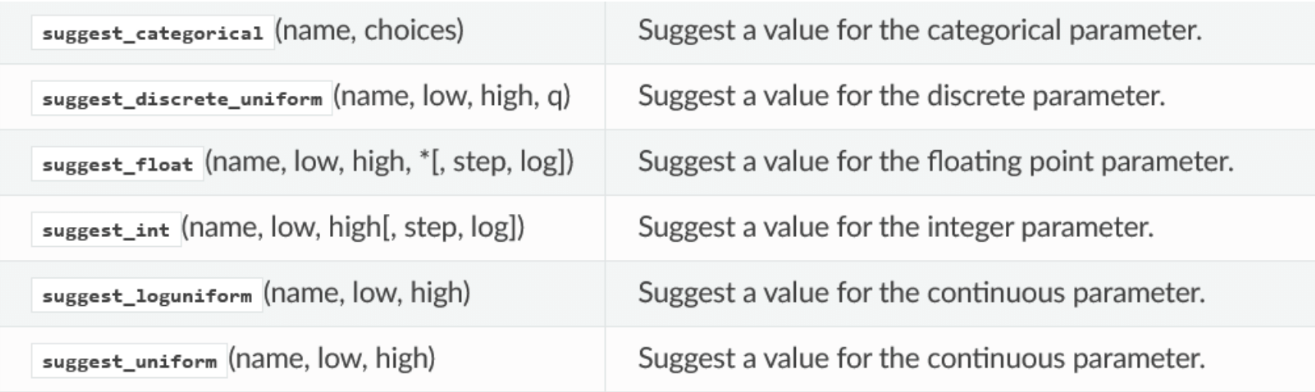

P.ej.: `dropout = trial.suggest_float('dropout', 0, 0.5, step = 0.1)`

In [9]:
# CARGADOR DE DATOS
root='../data' # directorio para guardar los datos
dataset = 'exchange_rate' # dataset a analizar (electricity, exchange_rate, solar-energy, traffic)
train_ratio = 0.6 # proporcion del conjunto de entrenamiento
valid_ratio = 0.2 # proporcion del conjunto de evaluacion
horizon = 3 # numero de pasos a realizar la prediccion
normalize = 2 # tipo de normalizacion en el DataLoaderS2
batch_size = 4 # tamanio de lote

# ENTRENAMIENTO
epochs = 5 # numero de epocas de entrenamiento
lr = 1e-4 # learning rate
opt = 'Adam' # optimizador (SGD, RMSProp, Adam, Adagrad, Adadelta)
weight_decay = 1e-5 # factor de penalizacion
L1Loss = True # tipo de perdida (L1Loss o MSELoss (False))
step_size = 100 # impresion de resultados en el paso step_size
num_split = 1
clip = 5
save_path_model = './model-exchange-3.pt' # ruta para guardar el modelo final

# MODELO
## GENERAL
gcn_true = True # agregar capa de graph convolution (MixProp)
build_adj = True # construir la matriz de adyacencia A (Graph Learning Layer)
dropout = 0.3
kernel_size = 7 # (auxiliar para el calculo del campo receptivo)
window = 24*7 # ventana de tiempo hacia atras (lags)
arquitecture = 'MTGNN' # MTGNN, MTGAN, MTGNNAH, MTGANAH
## connections
conv_channels = 16 # numero de canales en el gcn
residual_channels = 16 # numero de canales en las residuales (entrada a cada capa mtgnn)
skip_channels = 32 # numero de canales de las conexiones skip
## MixProp
gcn_depth = 2 # profundidad de la gcn (no debe ser grande -> over-smoothing)
propbeta = 0.05 # controla la proporcion de retencion del estado original
### GraphAttentionLayer
n_heads = 16 # numero de cabezas
concat = True # si se concatena en la salida de las cabezas o se toma el promedio (False)
## DilatedInception
kernel_set = [2,3,6,7] # lista de kernels que se ocupan en la capa Dilated inception
dilation_exponential = 2 # dilatacion exponencial (controla el tamanio del campo receptivo)
## GraphConstructor
# num_nodes -> el numero de nodos se calcula en el DataLoaderS2 (# de variables)
subgraph_size = 8 # tamanio del subgrafo -> topk(subgraph_size)
node_dim = 40 # dimension del embedding de los nodos
tanhalpha = 3 # tasa de saturacion de tanh
xd = None
## MTGNNLayer
layers = 5 # numero de capas mtgnn (TC & GC)
layer_norm_affline = False # hacer afin a los elementos en la normalizacion de capas
## MTGNNe
in_dim = 1 # canales de entrada para la convolucion inicial
end_channels = 64 # numero de canales en el modulo de salida
out_dim = 1 # canales de salida en la convolucion final

# VERBOSE
progress_train = True # observar la barra de progreso del entrenamiento
verbose_train = True # imprimir resultados de entrenamiento
verbose_train_epoch = False # mostrar la perdida de entrenamiento y validacion por epoca
verbose_summary = True # imprimir el numero de parametros del modelo
verbose_evaluation = True # imprimir las metricas en el conjunto de prueba
verbose_download = True # imprimir mensajes en la descarga de los datos
plot_losses = True # graficar las perdidas al terminar el entrenamiento
save_path_plot = None # save plot of train and valida losses

### 5.1 Definición de la función objetivo

Descarga y descompresión de los datos

In [10]:
# DATOS
## descarga y descompresion del conjunto de datos deseado
root = '../data'
dataset = 'exchange_rate'
verbose_download = False # print download messages
ds = TSDatasets(root, dataset, verbose_download)
ds_data_dir = ds.file_txt # path al conjunto de datos

Para realizar la optimización de los hiperparámetros en Optuna es necesario definir una función `objective(trial)`, donde se colocan los hiperparámetros a optimizar junto con su espacio de búsqueda, el DataLoader, la instancia del modelo y el método de entrenamiento. 

En el retorno se debe colocar el objetivo que se quiere maximizar o minimizar, en este caso se busca minimizar el RMSE en el conjunto de validación.

In [11]:
def objective(trial):
    ## carga del dataloader
    ## optimizacion del hiperparametro window: 24*7*1, 24*7*2, 24*7*3, 24*7*4
    window = trial.suggest_categorical('window', [168,336,504,672])
    # generacion del dataloader
    data = DataLoaderS2(ds_data_dir, train_ratio, valid_ratio, device, 
                      horizon, window, normalize)
    # obtencion del numero de nodos
    num_nodes = data.num_nodes

    # MODELO
    model = MTGNNe_Opt2(trial, gcn_true, build_adj, gcn_depth, num_nodes, kernel_set, kernel_size, subgraph_size,
                       node_dim, dilation_exponential, conv_channels, residual_channels, skip_channels,
                       end_channels, window, in_dim, out_dim, tanhalpha, layer_norm_affline,
                       arquitecture, n_heads, concat, xd)

    # mover modelo a cpu/gpu
    model = model.to(device)
    
    # ENTRENAMIENTO
    ## parametros del entrenamiento a optimizar
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    
    rse = train(model, data, num_nodes, trial, batch_size, epochs, lr, 
                opt, weight_decay, L1Loss, step_size, num_split, clip)

    # EVALUACION
    #if verbose_evaluation: print('\n')
    #vtest_acc, vtest_rae, vtest_corr, test_acc, test_rae, test_corr = evaluate_model(data,
    #                                                                               save_path_model,
    #                                                                               batch_size,
    #                                                                               verbose_evaluation)
    return rse

## 6 Estudio

Con la función `create_study` se crea una instancia del estudio, definiendo si el problema es de maximización o minimización, el tipo de muestreo para realizar la búsqueda o `Sampler`, y el depurador o `pruner`.

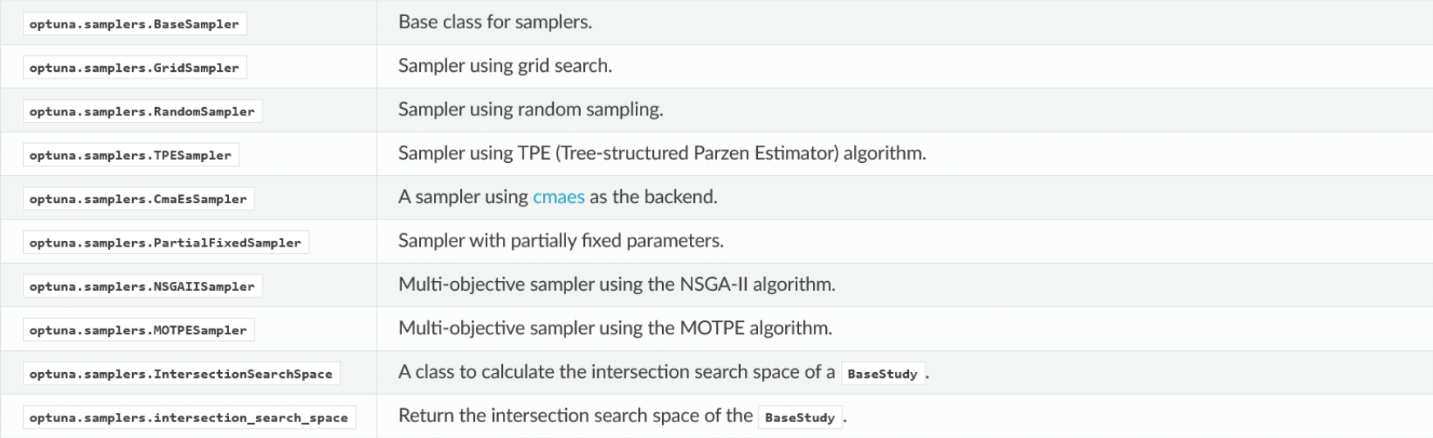

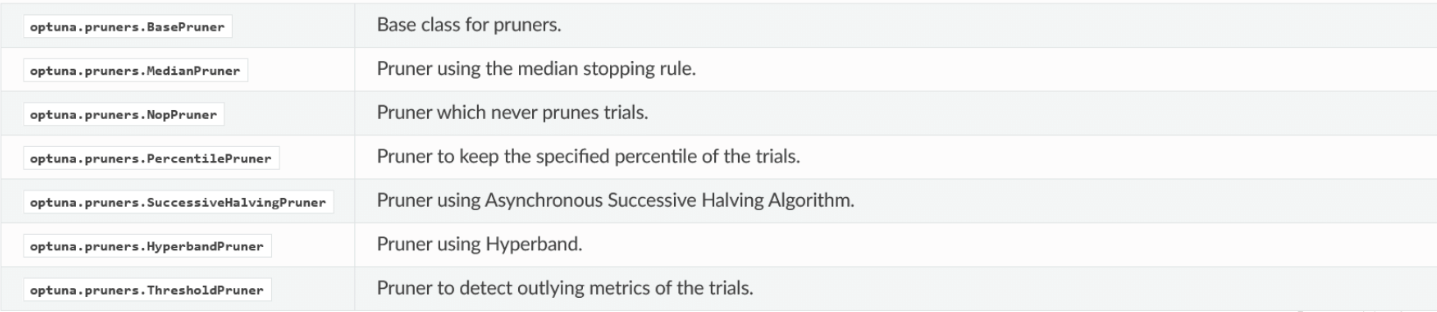

In [12]:
# instancia del estudio, en el cual se busca minimizar
study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner())
# ejecutar optimizacion
study.optimize(objective, n_trials=30)

[I 2022-12-01 01:13:02,039] A new study created in memory with name: no-name-21730722-fae8-4a79-bf40-5aea901bad35
[I 2022-12-01 02:04:57,421] Trial 0 finished with value: 0.02906573936343193 and parameters: {'window': 504, 'dropout': 0.1, 'conv_channels': 32, 'layers': 7, 'propbeta': 0.2, 'lr': 0.00016502558278320991}. Best is trial 0 with value: 0.02906573936343193.
[I 2022-12-01 02:41:31,939] Trial 1 finished with value: 0.04128648340702057 and parameters: {'window': 672, 'dropout': 0.0, 'conv_channels': 8, 'layers': 7, 'propbeta': 0.35000000000000003, 'lr': 0.0001909821610697027}. Best is trial 0 with value: 0.02906573936343193.
[I 2022-12-01 03:24:41,497] Trial 2 finished with value: 0.03118637390434742 and parameters: {'window': 504, 'dropout': 0.0, 'conv_channels': 16, 'layers': 7, 'propbeta': 0.0, 'lr': 0.003646452162842867}. Best is trial 0 with value: 0.02906573936343193.
[I 2022-12-01 03:26:27,518] Trial 3 pruned. 
[I 2022-12-01 03:27:39,739] Trial 4 pruned. 
[I 2022-12-01 03

Una vez finalizado la optimización se puede obtener información del estudio como el valor del conjunto de hiperparámetros que minimizaron la función objetivo en un número de intentos `n_trials`.

También se pueden obtener gráficas facilmente.

In [13]:
trial = study.best_trial

In [14]:
# impresion del mejor resultado junto con los valores
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.02906573936343193
Best hyperparameters: {'window': 504, 'dropout': 0.1, 'conv_channels': 32, 'layers': 7, 'propbeta': 0.2, 'lr': 0.00016502558278320991}


In [15]:
# dataframe con la informacion de todas las ejecuciones
df = study.trials_dataframe()
df.tail(5)

,number,value,datetime_start,datetime_complete,duration,params_conv_channels,params_dropout,params_layers,params_lr,params_propbeta,params_window,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,system_attrs_completed_rung_3,state
25,25,0.043585,2022-12-01 05:59:42.858465,2022-12-01 06:16:24.234644,0 days 00:16:41.376179,32,0.0,7,0.000438,0.30,168,0.234272,0.066829,0.043585,NaN,PRUNED
26,26,0.119028,2022-12-01 06:16:24.234644,2022-12-01 06:23:30.903404,0 days 00:07:06.668760,8,0.3,4,0.002610,0.25,336,0.052934,0.119028,NaN,NaN,PRUNED
27,27,0.344787,2022-12-01 06:23:30.904401,2022-12-01 06:25:54.808865,0 days 00:02:23.904464,32,0.5,3,0.093097,0.40,672,0.344787,NaN,NaN,NaN,PRUNED
28,28,0.122628,2022-12-01 06:25:54.809862,2022-12-01 06:26:49.606405,0 days 00:00:54.796543,32,0.2,1,0.000044,0.25,336,0.209516,0.122628,NaN,NaN,PRUNED
29,29,0.071693,2022-12-01 06:26:49.606405,2022-12-01 06:34:25.013484,0 days 00:07:35.407079,16,0.4,4,0.000060,0.50,672,0.071693,NaN,NaN,NaN,PRUNED


En la siguiente gráfica se muestra una estimación de la importancia de los hiperparámetros en el proceso de optimización

C:\Users\daniel\.conda\envs\dots\lib\site-packages\ipykernel_launcher.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

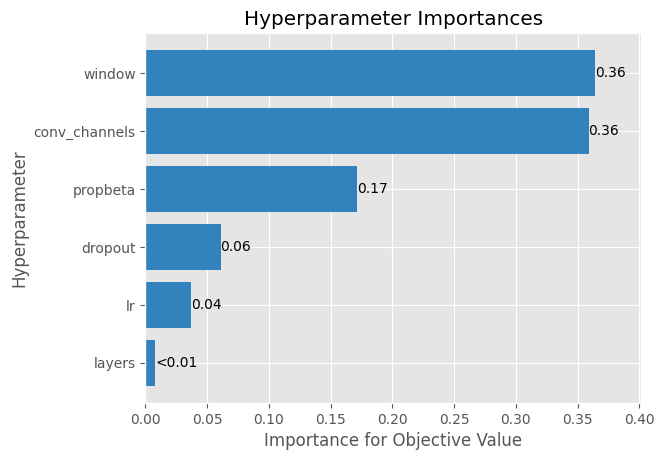

In [20]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [1]:
#optuna.visualization.plot_param_importances(study)